# Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Data Loading and Initial Exploration

## Load Data

In [2]:
df = pd.read_csv('train.csv')

## Preview Data

In [3]:
df.head()

,id,value_increased,Ability,Potential,Positions,Caps / Goals,Foot,Height,Weight,Aerial Reach,...,Dribbling,Finishing,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Penalty Taking,Tackling,Technique
0,74044,False,46.0,NaN,AMC,NaN,Right,178 CM,72 KG,NaN,...,45.0,35.0,35.0,30.0,35.0,40.0,40.0,25.0,45.0,50.0
1,83969,False,48.0,NaN,GK,NaN,Right,185 CM,82 KG,55.0,...,NaN,NaN,35.0,NaN,NaN,NaN,NaN,15.0,NaN,55.0
2,94664,False,58.0,NaN,DL DC,NaN,Left,185 CM,80 KG,NaN,...,40.0,30.0,15.0,65.0,35.0,50.0,55.0,55.0,70.0,45.0
3,46208,True,38.0,NaN,DC,NaN,Right,185 CM,74 KG,NaN,...,15.0,10.0,20.0,70.0,10.0,35.0,70.0,20.0,55.0,10.0
4,77969,False,47.0,NaN,GK,NaN,Right,193 CM,73 KG,35.0,...,NaN,NaN,40.0,NaN,NaN,NaN,NaN,15.0,NaN,15.0


## Basic Information

In [4]:
df.shape

(465, 56)

In [5]:
df.describe()

,id,Ability,Potential,Aerial Reach,Command of Area,Communication,Eccentricity,First Touch,Handling,Kicking,...,Dribbling,Finishing,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Penalty Taking,Tackling,Technique
count,465.000000,465.000000,43.000000,32.000000,32.000000,32.00000,32.00000,465.000000,32.00000,32.000000,...,433.000000,433.000000,465.000000,433.000000,433.000000,433.000000,433.000000,465.000000,433.000000,465.000000
mean,55474.206452,44.724731,63.604651,57.500000,53.437500,50.15625,37.65625,54.784946,58.75000,55.468750,...,49.953811,42.263279,34.634409,45.219400,40.484988,28.556582,40.011547,30.935484,44.087760,54.225806
std,26644.428530,16.136324,17.434421,12.181424,13.406637,11.10684,16.01332,14.083227,10.16001,11.313664,...,17.149201,16.789960,14.646543,14.357712,13.931724,15.345018,16.296226,17.010903,17.665531,15.180047
min,10301.000000,0.000000,30.000000,30.000000,15.000000,30.00000,15.00000,5.000000,40.00000,25.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
25%,32399.000000,39.000000,49.500000,53.750000,48.750000,43.75000,25.00000,50.000000,50.00000,50.000000,...,40.000000,30.000000,25.000000,35.000000,30.000000,15.000000,25.000000,15.000000,30.000000,50.000000
50%,55236.000000,48.000000,68.000000,60.000000,55.000000,50.00000,30.00000,55.000000,60.00000,55.000000,...,55.000000,40.000000,35.000000,45.000000,40.000000,30.000000,40.000000,30.000000,45.000000,55.000000
75%,77172.000000,55.000000,75.000000,65.000000,61.250000,60.00000,50.00000,65.000000,65.00000,65.000000,...,65.000000,55.000000,45.000000,55.000000,50.000000,40.000000,55.000000,45.000000,60.000000,65.000000
max,99912.000000,80.000000,90.000000,85.000000,75.000000,70.00000,70.00000,85.000000,80.00000,70.000000,...,80.000000,90.000000,75.000000,80.000000,75.000000,75.000000,75.000000,85.000000,80.000000,85.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 56 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      465 non-null    int64  
 1   value_increased         465 non-null    bool   
 2   Ability                 465 non-null    float64
 3   Potential               43 non-null     float64
 4   Positions               465 non-null    object 
 5   Caps / Goals            16 non-null     object 
 6   Foot                    465 non-null    object 
 7   Height                  465 non-null    object 
 8   Weight                  465 non-null    object 
 9   Aerial Reach            32 non-null     float64
 10  Command of Area         32 non-null     float64
 11  Communication           32 non-null     float64
 12  Eccentricity            32 non-null     float64
 13  First Touch             465 non-null    float64
 14  Handling                32 non-null     fl

# Exploratory Data Analysis (EDA)

## Correlation Analysis

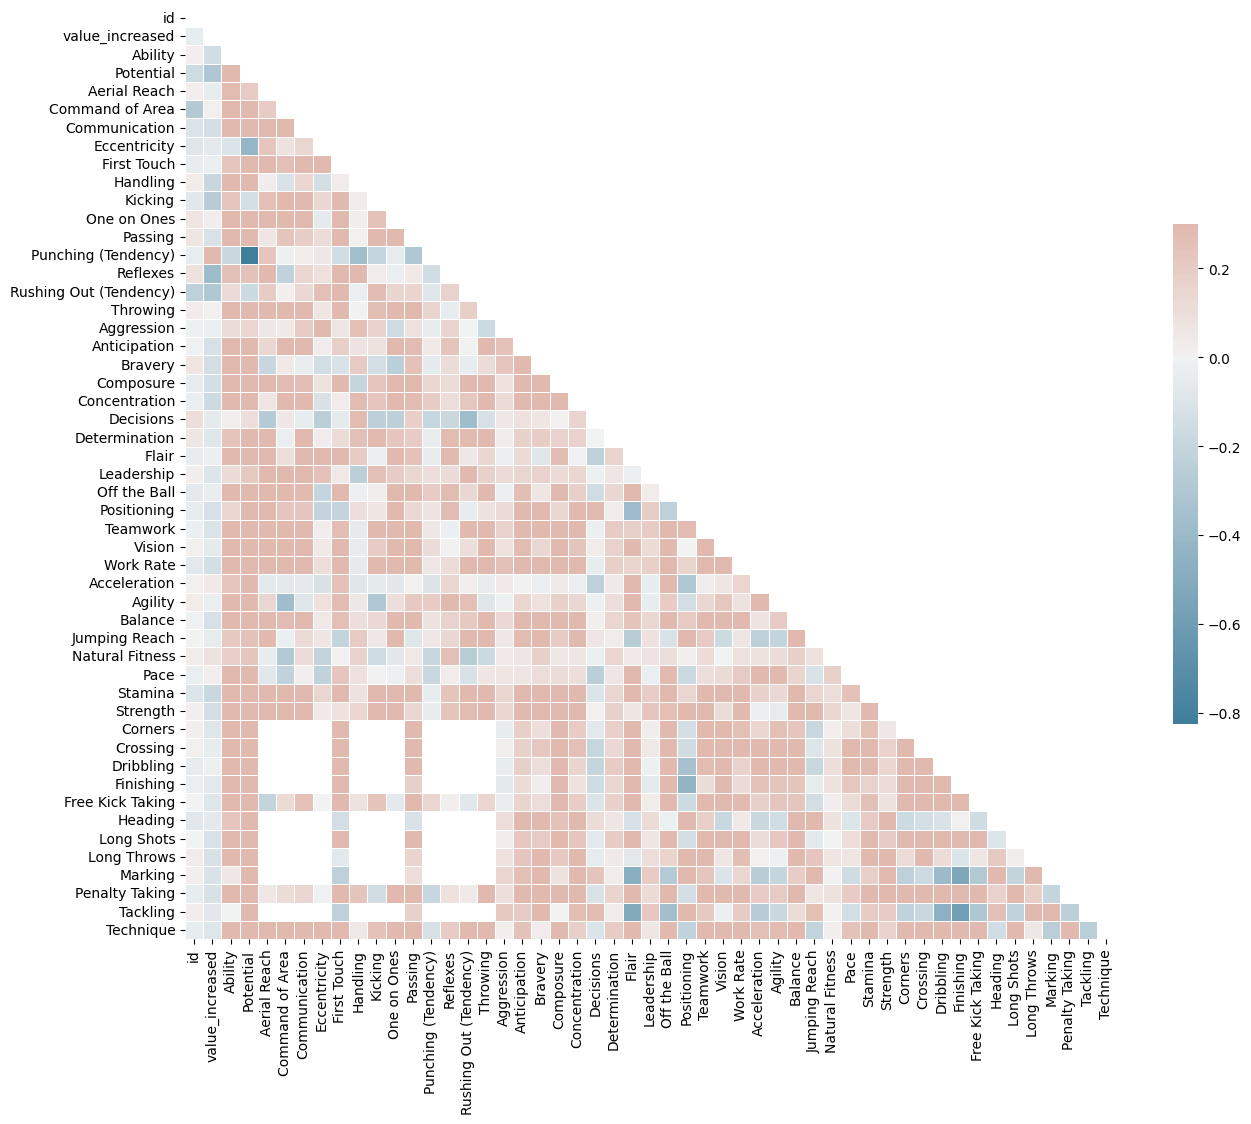

In [7]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 13))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Data Cleaning

In [8]:
df.select_dtypes(include='object').head()

,Positions,Caps / Goals,Foot,Height,Weight
0,AMC,NaN,Right,178 CM,72 KG
1,GK,NaN,Right,185 CM,82 KG
2,DL DC,NaN,Left,185 CM,80 KG
3,DC,NaN,Right,185 CM,74 KG
4,GK,NaN,Right,193 CM,73 KG


### Caps / Goals Column Seperation

In [9]:
df['Caps / Goals'].fillna('0 / 0', inplace=True)

In [10]:
df['Caps'] = df['Caps / Goals'].str.split('/').apply(lambda x: int(x[0]))

In [11]:
df['Goals'] = df['Caps / Goals'].str.split('/').apply(lambda x: int(x[1]))

In [12]:
del df['Caps / Goals']

### Height and Weight Columns' Conversion to Integer

In [13]:
df['Height'] = df['Height'].replace('CM', '', regex=True).astype(int)

In [14]:
df['Weight'] = df['Weight'].replace('KG', '', regex=True).astype(int)

### Foot Column is Made Numeric

In [15]:
df['Foot'].value_counts()

Foot
Right    341
Left     124
Name: count, dtype: int64

In [16]:
df['Foot'] = df['Foot'].map({'Left': 0, 'Right': 1})

### Position Column is OneHotEncoded

In [17]:
positions = []

In [18]:
for x in df['Positions'].str.split().values:
    positions.extend(x)

In [19]:
unique_positions = list(set(positions))

In [20]:
unique_positions

['GK',
 'DR',
 'DM',
 'MR',
 'AML',
 'ML',
 'AMC',
 'WBR',
 'DL',
 'AMR',
 'WBL',
 'MC',
 'ST',
 'DC']

In [21]:
position_matrix = []

In [22]:
for row in df.iterrows():
    row_positions = row[1]['Positions'].split()
    dict_positions = {x:0 for x in unique_positions}
    for position in row_positions:
        dict_positions[position] += 1
        position_matrix.append({row[1]['id']: dict_positions})

In [23]:
flattened_data = []

for item in position_matrix:
    for id_value, attributes in item.items():
        row = {'id': id_value}
        row.update(attributes)
        flattened_data.append(row)

positions_df = pd.DataFrame(flattened_data)

In [24]:
positions_df = positions_df.drop_duplicates()

In [25]:
df = df.merge(positions_df, on='id', how='left')

In [26]:
df = df.drop(columns=['Positions'])

### Filling Null Values with 0

In [27]:
df = df.fillna(0)

In [28]:
df.head()

,id,value_increased,Ability,Potential,Foot,Height,Weight,Aerial Reach,Command of Area,Communication,...,AML,ML,AMC,WBR,DL,AMR,WBL,MC,ST,DC
0,74044,False,46.0,0.0,1,178,72,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,83969,False,48.0,0.0,1,185,82,55.0,60.0,70.0,...,0,0,0,0,0,0,0,0,0,0
2,94664,False,58.0,0.0,0,185,80,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
3,46208,True,38.0,0.0,1,185,74,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,77969,False,47.0,0.0,1,193,73,35.0,40.0,35.0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 70 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      465 non-null    int64  
 1   value_increased         465 non-null    bool   
 2   Ability                 465 non-null    float64
 3   Potential               465 non-null    float64
 4   Foot                    465 non-null    int64  
 5   Height                  465 non-null    int64  
 6   Weight                  465 non-null    int64  
 7   Aerial Reach            465 non-null    float64
 8   Command of Area         465 non-null    float64
 9   Communication           465 non-null    float64
 10  Eccentricity            465 non-null    float64
 11  First Touch             465 non-null    float64
 12  Handling                465 non-null    float64
 13  Kicking                 465 non-null    float64
 14  One on Ones             465 non-null    fl

# Model Development

## Undersampling

In [30]:
df.value_increased.value_counts(normalize=True)

value_increased
False    0.849462
True     0.150538
Name: proportion, dtype: float64

### Train and Test Split

In [31]:
X = df.drop(columns = ['id', 'value_increased'])
y = df['value_increased'].astype(int)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,stratify=y, test_size=0.3, random_state=42)

In [33]:
X_train.head()

,Ability,Potential,Foot,Height,Weight,Aerial Reach,Command of Area,Communication,Eccentricity,First Touch,...,AML,ML,AMC,WBR,DL,AMR,WBL,MC,ST,DC
377,53.0,0.0,1,179,75,0.0,0.0,0.0,0.0,50.0,...,0,0,0,0,0,0,0,1,0,0
326,40.0,0.0,1,196,80,0.0,0.0,0.0,0.0,45.0,...,0,0,0,0,0,0,0,0,1,0
131,57.0,0.0,0,175,69,0.0,0.0,0.0,0.0,60.0,...,1,0,0,0,0,0,0,0,0,0
42,40.0,0.0,0,170,59,0.0,0.0,0.0,0.0,45.0,...,0,1,0,0,0,0,1,0,0,0
382,52.0,0.0,1,164,61,0.0,0.0,0.0,0.0,60.0,...,1,0,1,0,0,0,0,0,0,0


In [34]:
y_train.head()

377    0
326    0
131    0
42     0
382    0
Name: value_increased, dtype: int64

## XGBoost

In [35]:
import xgboost as xgb

# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(tree_method="hist", scale_pos_weight=9, early_stopping_rounds = 2,)
# Fit the model, test sets are used for early stopping.
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
# Save model into JSON format.
clf.save_model("clf.json")

[0]	validation_0-logloss:0.71928
[1]	validation_0-logloss:0.65551
[2]	validation_0-logloss:0.63480
[3]	validation_0-logloss:0.57152
[4]	validation_0-logloss:0.53786
[5]	validation_0-logloss:0.51560
[6]	validation_0-logloss:0.50222
[7]	validation_0-logloss:0.48633
[8]	validation_0-logloss:0.48214
[9]	validation_0-logloss:0.47123
[10]	validation_0-logloss:0.46712
[11]	validation_0-logloss:0.46492
[12]	validation_0-logloss:0.45822
[13]	validation_0-logloss:0.44827
[14]	validation_0-logloss:0.45265
[15]	validation_0-logloss:0.46120


## Classification Report

In [36]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       119
           1       0.33      0.19      0.24        21

    accuracy                           0.82       140
   macro avg       0.60      0.56      0.57       140
weighted avg       0.79      0.82      0.80       140



In [37]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0])

## Preprocess Pipeline Preparation

In [38]:
def prep_pipe(data):
    df = data.copy()
    df['Caps / Goals'].fillna('0 / 0', inplace=True)
    df['Caps'] = df['Caps / Goals'].str.split('/').apply(lambda x: int(x[0]))
    df['Goals'] = df['Caps / Goals'].str.split('/').apply(lambda x: int(x[1]))
    del df['Caps / Goals']
    df['Height'] = df['Height'].replace('CM', '', regex=True).astype(int)
    df['Weight'] = df['Weight'].replace('KG', '', regex=True).astype(int)
    df['Foot'] = df['Foot'].map({'Left': 0, 'Right': 1})
    
    position_matrix = []
    for row in df.iterrows():
        row_positions = row[1]['Positions'].split()
        dict_positions = {x:0 for x in unique_positions}
        for position in row_positions:
            dict_positions[position] += 1
            position_matrix.append({row[1]['id']: dict_positions})
   
    flattened_data = []

    for item in position_matrix:
        for id_value, attributes in item.items():
            row = {'id': id_value}
            row.update(attributes)
            flattened_data.append(row)

    positions_df = pd.DataFrame(flattened_data)
    
    positions_df = positions_df.drop_duplicates()

    df = df.merge(positions_df, on='id', how='left')

    df = df.drop(columns=['Positions', 'id'])    
    
    df = df.fillna(0)

    return df

## Test Datasının Hazırlanması

In [39]:
test_df = pd.read_csv('test.csv')

In [40]:
test_df.head()

,id,Ability,Potential,Positions,Caps / Goals,Foot,Height,Weight,Aerial Reach,Command of Area,...,Dribbling,Finishing,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Penalty Taking,Tackling,Technique
0,13436,40.0,NaN,DR,NaN,Right,165 CM,60 KG,NaN,NaN,...,45.0,20.0,35.0,30.0,20.0,35.0,55.0,30.0,40.0,30.0
1,49790,42.0,NaN,DC,NaN,Right,191 CM,79 KG,NaN,NaN,...,10.0,25.0,30.0,40.0,25.0,5.0,55.0,5.0,65.0,20.0
2,73335,40.0,NaN,DM,NaN,Left,182 CM,74 KG,NaN,NaN,...,25.0,20.0,25.0,40.0,30.0,5.0,60.0,5.0,60.0,40.0
3,15949,39.0,NaN,GK,NaN,Right,187 CM,74 KG,55.0,40.0,...,NaN,NaN,10.0,NaN,NaN,NaN,NaN,10.0,NaN,25.0
4,26364,38.0,NaN,AMC,NaN,Left,179 CM,67 KG,NaN,NaN,...,50.0,60.0,60.0,55.0,50.0,15.0,35.0,35.0,25.0,65.0


In [41]:
test_df = prep_pipe(test_df)

In [70]:
## PyCaret

from pycaret.classification import ClassificationExperiment
data = df.drop(columns=['id'])
s = ClassificationExperiment()
s.setup(data, target = 'value_increased',session_id = 123)

,Description,Value
0,Session id,123
1,Target,value_increased
2,Target type,Binary
3,Original data shape,"(465, 69)"
4,Transformed data shape,"(465, 69)"
5,Transformed train set shape,"(325, 69)"
6,Transformed test set shape,"(140, 69)"
7,Numeric features,68
8,Preprocess,True
9,Imputation type,simple


In [83]:
best = s.compare_models(n_select=16,sort='f1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.4209,0.5634,0.7750,0.1805,0.2911,0.0613,0.0940,0.0050
ada,Ada Boost Classifier,0.7878,0.5971,0.1650,0.2069,0.1778,0.0663,0.0660,0.0150
lr,Logistic Regression,0.7727,0.5323,0.1200,0.2067,0.1471,0.0222,0.0284,0.0250
lda,Linear Discriminant Analysis,0.7692,0.5105,0.1200,0.1467,0.1300,0.0068,0.0039,0.0060
xgboost,Extreme Gradient Boosting,0.8371,0.5939,0.0800,0.2750,0.1175,0.0715,0.0937,0.0130
knn,K Neighbors Classifier,0.8244,0.6020,0.0600,0.2500,0.0952,0.0351,0.0559,0.0050
lightgbm,Light Gradient Boosting Machine,0.8368,0.6222,0.0600,0.2500,0.0952,0.0518,0.0724,0.0920
ridge,Ridge Classifier,0.8184,0.5066,0.0600,0.2000,0.0905,0.0223,0.0316,0.0060
dt,Decision Tree Classifier,0.7137,0.4613,0.1000,0.0593,0.0737,-0.0797,-0.0856,0.0060
rf,Random Forest Classifier,0.8554,0.5510,0.0400,0.2000,0.0667,0.0595,0.0836,0.0290


In [84]:
best = best[1]

## Model Tuning

In [85]:
tuned_model = s.tune_model(best,optimize='f1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8485,0.5429,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8485,0.6143,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8485,0.4179,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.8485,0.5143,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8485,0.3750,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.8438,0.5982,0.0000,0.0000,0.0000,-0.0526,-0.0679
6,0.8438,0.6444,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.8438,0.6370,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8438,0.5556,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


## Model Finalization

In [76]:
final_model = s.finalize_model(best)